<a href="https://colab.research.google.com/github/Runchen-Zhang/Gitlearn/blob/main/mnist_mlp_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP training on MNIST

In [21]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST

In [22]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):
    """
    Initialize MLP parameters using Gaussian weight initialization.

    Args:
        layer_widths: list of layer sizes.
        parent_key: JAX PRNGKey.
        scale: float, initialization scale factor.

    Returns:
        params: list of [W, b] pairs.
    """
    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [23]:
def MLP_predict(params, x):
    """
    Forward pass of the MLP.

    Args:
        params: model parameters.
        x: input vector or batch of vectors.

    Returns:
        Log-softmax predictions.
    """
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [25]:
def create_batches(images, labels, batch_size, rng_key):
    """
    Create shuffled minibatches using pure NumPy/JAX operations.
    This replaces the PyTorch DataLoader.
    """
    num_samples = images.shape[0]
    perm = jax.random.permutation(rng_key, num_samples)

    num_batches = num_samples // batch_size
    perm = perm[:num_batches * batch_size]
    perm = perm.reshape((num_batches, batch_size))

    for idx in perm:
        yield images[idx], labels[idx]


# Load MNIST using torchvision only once (for convenience)
# Then convert everything into NumPy/JAX arrays, no DataLoader used later.
train_dataset = MNIST(root='train_mnist', train=True, download=True)
test_dataset = MNIST(root='test_mnist', train=False, download=True)

train_images = jnp.array(train_dataset.data.reshape(len(train_dataset), -1), dtype=jnp.float32)
train_labels = jnp.array(train_dataset.targets, dtype=jnp.int32)

test_images = jnp.array(test_dataset.data.reshape(len(test_dataset), -1), dtype=jnp.float32)
test_labels = jnp.array(test_dataset.targets, dtype=jnp.int32)

In [26]:
num_epochs = 10
batch_size = 128

def loss_fn(params, imgs, labels_onehot):
    """
    Compute mean negative log-likelihood loss for a batch.
    """
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * labels_onehot)

def accuracy(params, dataset_imgs, dataset_labels):
    """
    Return the proportion of correctly predicted labels.
    """
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_labels == pred_classes)

@jit
def update(params, imgs, labels_onehot, lr=0.01):
    """
    Compute gradients using value_and_grad and apply a simple SGD update.
    """
    loss, grads = value_and_grad(loss_fn)(params, imgs, labels_onehot)

    return loss, jax.tree.map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    epoch_key, key = jax.random.split(key)
    for cnt, (imgs, labels) in enumerate(create_batches(train_images, train_labels, batch_size, epoch_key)):

        gt_labels = jax.nn.one_hot(labels, len(MNIST.classes))

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_labels)} test acc = {accuracy(MLP_params, test_images, test_labels)}')


0.24284689
0.08699149
0.06093214
0.04342049
0.05763197
0.04140502
0.036947496
0.037265833
0.029107142
0.024983943
Epoch 0, train acc = 0.9099000096321106 test acc = 0.9154999852180481
0.027074313
0.02210153
0.034005105
0.03430944
0.03753181
0.034499902
0.019582402
0.024776643
0.02572213
0.023869652
Epoch 1, train acc = 0.9343000054359436 test acc = 0.9361000061035156
0.023371115
0.026164014
0.023950592
0.017717088
0.019943137
0.03501333
0.01854203
0.024000933
0.023606459
0.026976386
Epoch 2, train acc = 0.9436833262443542 test acc = 0.9426999688148499
0.021696206
0.025063684
0.014426428
0.011038904
0.0077834562
0.019851683
0.013498954
0.015638951
0.019354952
0.0093064215
Epoch 3, train acc = 0.9544000029563904 test acc = 0.9538999795913696
0.014358518
0.011946589
0.024761846
0.014029383
0.013106026
0.0059227995
0.03217725
0.020806082
0.011530126
0.016703637
Epoch 4, train acc = 0.9585500359535217 test acc = 0.9539999961853027
0.013309258
0.016539952
0.011090725
0.01606728
0.011851315
0

(28, 28)
pred 8
label 8


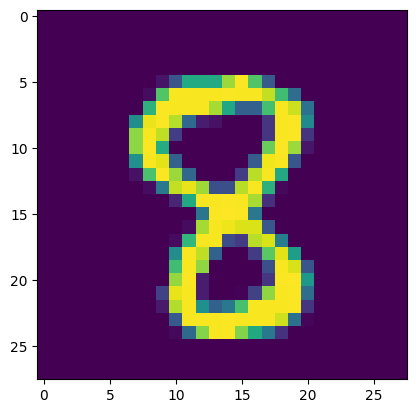

In [27]:
test_iter = create_batches(test_images, test_labels, batch_size, key)
imgs, labels = next(test_iter)
img = imgs[2].reshape(mnist_img_size)
label_onehot = labels[2]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('label', label_onehot)

plt.imshow(img); plt.show()

# Visualizations

(512, 784)
(28, 28)


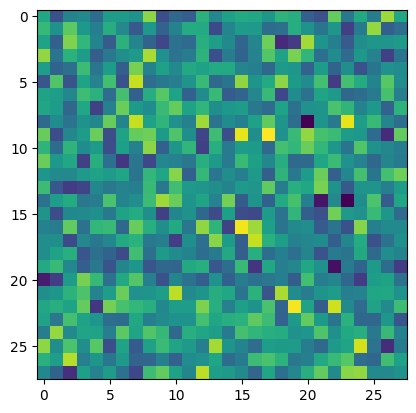

In [28]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


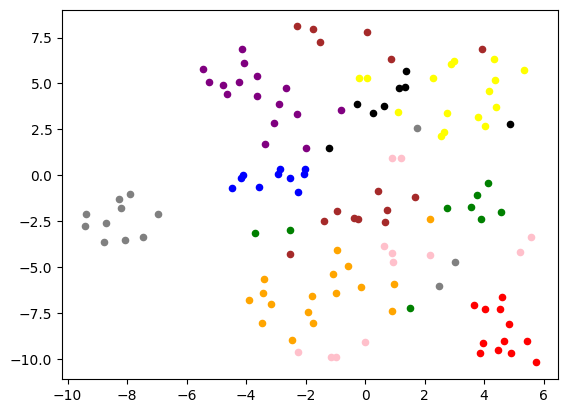

In [29]:
# todo: visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    """
    Compute the last hidden-layer activation.
    """
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
test_iter = create_batches(test_images, test_labels, batch_size, key)
imgs, labels = next(test_iter)

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 256)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
    4: "yellow",
    5: "pink",
    6: "gray",
    7: "purple",
    8: "brown",
    9: "black"
}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()